In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [2]:
# Set folder path
data_folder = Path("task3_dataset/")
vibration_folder = Path(data_folder/"vibrationdata/")

# Set file paths
prod_log_path = data_folder / "production_log.csv"
prod_qual_path = data_folder / "product_quality_log.csv"

# Read production log and quality log files
df_prod_log = pd.read_csv(prod_log_path, index_col = 0)
df_qual_log = pd.read_csv(prod_qual_path, index_col = 0)

# Convert the timestamp format for uniformity
df_prod_log['timestamp'] = pd.to_datetime(df_prod_log['timestamp'], format = '%Y-%m-%d_%H-%M-%S')


In [3]:
display(df_prod_log)
display(df_qual_log)

,timestamp,product_id
0,2021-05-17 08:12:48,P3.2.500
1,2021-05-17 08:12:51,P3.2.501
2,2021-05-17 08:12:54,P3.2.502
3,2021-05-17 08:12:57,P3.2.503
4,2021-05-17 08:13:00,P3.2.504
...,...,...
1651,2021-05-17 09:35:21,P3.2.2151
1652,2021-05-17 09:35:24,P3.2.2152
1653,2021-05-17 09:35:27,P3.2.2153
1654,2021-05-17 09:35:30,P3.2.2154


,machine_id,product_id,quality
0,Printer F0815,P3.2.500,OK
1,Printer F0815,P3.2.501,OK
2,Printer F0815,P3.2.502,OK
3,Printer F0815,P3.2.503,OK
4,Printer F0815,P3.2.504,OK
...,...,...,...
1651,Printer F0815,P3.2.2151,nOK
1652,Printer F0815,P3.2.2152,nOK
1653,Printer F0815,P3.2.2153,nOK
1654,Printer F0815,P3.2.2154,nOK


In [4]:
# Merging product quality log file data and production log file data. Key = 'product_id'

df_prod_qual = df_prod_log.merge(df_qual_log, on = 'product_id', how = 'inner')
df_prod_qual = df_prod_qual.set_index('timestamp')

In [5]:
display(df_prod_qual)

,product_id,machine_id,quality
timestamp,,,
2021-05-17 08:12:48,P3.2.500,Printer F0815,OK
2021-05-17 08:12:51,P3.2.501,Printer F0815,OK
2021-05-17 08:12:54,P3.2.502,Printer F0815,OK
2021-05-17 08:12:57,P3.2.503,Printer F0815,OK
2021-05-17 08:13:00,P3.2.504,Printer F0815,OK
...,...,...,...
2021-05-17 09:35:21,P3.2.2151,Printer F0815,nOK
2021-05-17 09:35:24,P3.2.2152,Printer F0815,nOK
2021-05-17 09:35:27,P3.2.2153,Printer F0815,nOK


In [6]:
# print(df_prod_qual[df_prod_qual['quality'] == 'OK'].count())
# df_prod_qual[df_prod_qual['quality'] == 'nOK'].count()

In [7]:
#Test code - IGNORE
file = "2021-05-17_08-12-48"
vib_df1 = pd.read_csv(vibration_folder/file, sep = "\t", header = None)
vib_df1.columns = ['Sensor1','Sensor2']

### Feature Extraction/Creation

In [8]:
# Features extracted for each sensor:
# 1.Max 2.Min 3.Mean 4.Standard Deviation 5.Root Mean Square

def extractFeature(df):
    rms_sensor1 = math.sqrt((df['Sensor1'] ** 2).mean())
    rms_sensor2 = math.sqrt((df['Sensor2'] ** 2).mean())
    feature_array = np.array([ df['Sensor1'].max(), df['Sensor2'].max(),df['Sensor1'].min(),df['Sensor2'].min(),df['Sensor1'].mean(), df['Sensor2'].mean(),df['Sensor1'].std(),df['Sensor2'].std(), rms_sensor1, rms_sensor2])
    return feature_array

In [9]:
# Test code- IGNORE
feature_array = extractFeature(vib_df1)
print(feature_array)

[ 0.271       0.254      -0.75       -0.488      -0.11753828 -0.11665913
  0.09280735  0.0794944   0.14975991  0.141168  ]


### Reading vibration data file and creating feature matrix

In [10]:
feature_df = pd.DataFrame([])

for file in os.listdir(vibration_folder):
    vib_data = pd.read_csv(vibration_folder/file, sep = "\t", header = None)
    vib_data.columns = ['Sensor1','Sensor2']

    #Function call to extract features
    feature_array = extractFeature(vib_data)
    vib_df = pd.DataFrame([feature_array])
    
    #Converting string filename to datetime object
    file_datetime = datetime.strptime(str(file), '%Y-%m-%d_%H-%M-%S')
    vib_df.index = [file_datetime]
    
    feature_df = feature_df.append(vib_df)

In [11]:
feature_df.columns = ['S1_max', 'S2_max','S1_min','S2_min','S1_mean','S2_mean','S1_std','S2_std','S1_rms','S2_rms']

In [12]:
df_merged = pd.merge(df_prod_qual, feature_df, left_index = True, right_index = True)

In [13]:
display(df_merged)

,product_id,machine_id,quality,S1_max,S2_max,S1_min,S2_min,S1_mean,S2_mean,S1_std,S2_std,S1_rms,S2_rms
2021-05-17 08:12:48,P3.2.500,Printer F0815,OK,0.271,0.254,-0.750,-0.488,-0.117538,-0.116659,0.092807,0.079494,0.149760,0.141168
2021-05-17 08:12:51,P3.2.501,Printer F0815,OK,0.269,0.229,-0.620,-0.505,-0.116943,-0.115859,0.093839,0.079616,0.149936,0.140576
2021-05-17 08:12:54,P3.2.502,Printer F0815,OK,0.278,0.276,-0.540,-0.496,-0.117447,-0.117435,0.094562,0.081349,0.150782,0.142858
2021-05-17 08:12:57,P3.2.503,Printer F0815,OK,0.273,0.234,-0.742,-0.569,-0.116196,-0.116182,0.094652,0.080029,0.149867,0.141077
2021-05-17 08:13:00,P3.2.504,Printer F0815,OK,0.305,0.239,-0.632,-0.483,-0.116490,-0.116388,0.094036,0.079940,0.149707,0.141196
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-17 09:35:21,P3.2.2151,Printer F0815,nOK,0.466,0.388,-0.732,-0.620,-0.117700,-0.117854,0.145685,0.117771,0.187287,0.166610
2021-05-17 09:35:24,P3.2.2152,Printer F0815,nOK,0.518,0.488,-0.781,-0.598,-0.116901,-0.117200,0.146956,0.117993,0.187779,0.166306
2021-05-17 09:35:27,P3.2.2153,Printer F0815,nOK,0.547,0.496,-0.776,-0.830,-0.116428,-0.116559,0.164493,0.142499,0.201525,0.184095
2021-05-17 09:35:30,P3.2.2154,Printer F0815,nOK,0.728,0.552,-0.869,-0.791,-0.118304,-0.118188,0.170994,0.150242,0.207927,0.191155


### Visualization of sensor data

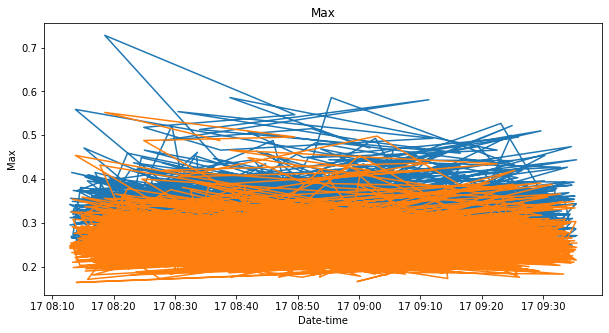

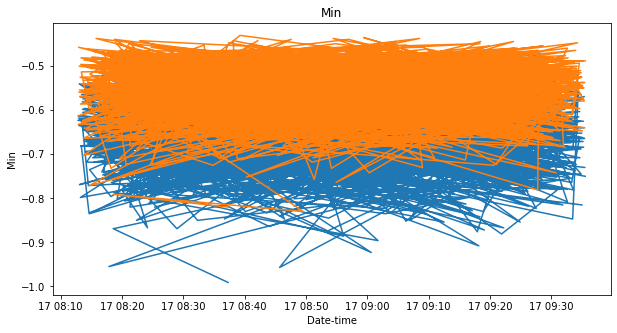

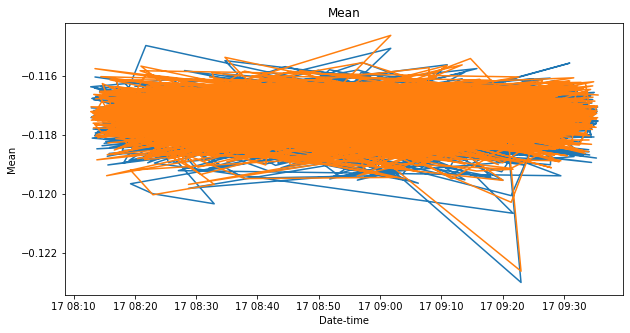

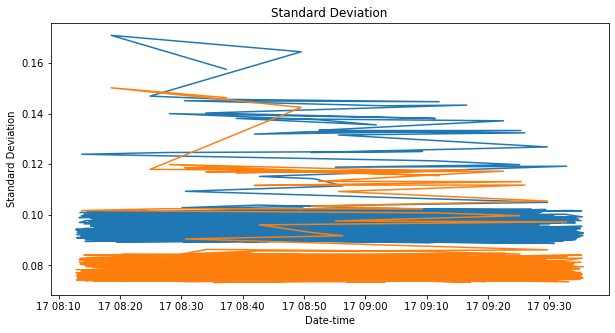

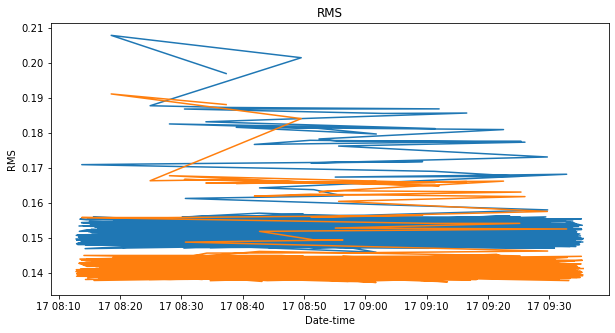

In [14]:
# Features of each sensor:
feature_s1= df_merged[['S1_max','S1_min','S1_mean','S1_std','S1_rms']]
feature_s2= df_merged[['S2_max','S2_min','S2_mean','S2_std','S2_rms']]

feature_s1.columns=['Max','Min','Mean','Standard Deviation','RMS']
feature_s2.columns=['Max','Min','Mean','Standard Deviation','RMS']

for i, col in enumerate(feature_s1.columns):

    plt.figure(figsize=(10,5))
    plt.plot(feature_df.index, feature_s1[col])
    plt.plot(feature_df.index, feature_s2[col])
    plt.xlabel('Date-time')
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [15]:
clipped_features = df_merged.loc['2021-05-17 09:33:03': '2021-05-17 09:34:00', 'S1_max':'S2_rms']
print(clipped_features)

                     S1_max  S2_max  S1_min  S2_min   S1_mean   S2_mean  \
2021-05-17 09:33:03   0.361   0.334  -0.625  -0.549 -0.117633 -0.117753   
2021-05-17 09:33:06   0.315   0.400  -0.627  -0.615 -0.116826 -0.117571   
2021-05-17 09:33:09   0.442   0.288  -0.649  -0.549 -0.117306 -0.117639   
2021-05-17 09:33:12   0.366   0.261  -0.735  -0.566 -0.117131 -0.116978   
2021-05-17 09:33:15   0.337   0.220  -0.664  -0.664 -0.117806 -0.117501   
2021-05-17 09:33:18   0.339   0.300  -0.618  -0.627 -0.117197 -0.117318   
2021-05-17 09:33:21   0.264   0.291  -0.630  -0.520 -0.117820 -0.117513   
2021-05-17 09:33:24   0.337   0.286  -0.596  -0.522 -0.117694 -0.117256   
2021-05-17 09:33:27   0.286   0.281  -0.591  -0.518 -0.118010 -0.117577   
2021-05-17 09:33:30   0.249   0.208  -0.647  -0.564 -0.117238 -0.117446   
2021-05-17 09:33:33   0.339   0.234  -0.676  -0.486 -0.117773 -0.118295   
2021-05-17 09:33:36   0.415   0.278  -0.627  -0.613 -0.117180 -0.116843   
2021-05-17 09:33:39   0.3

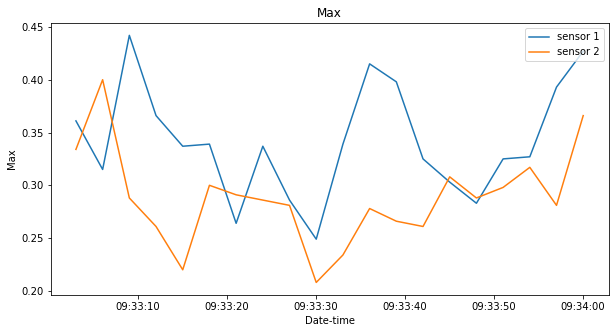

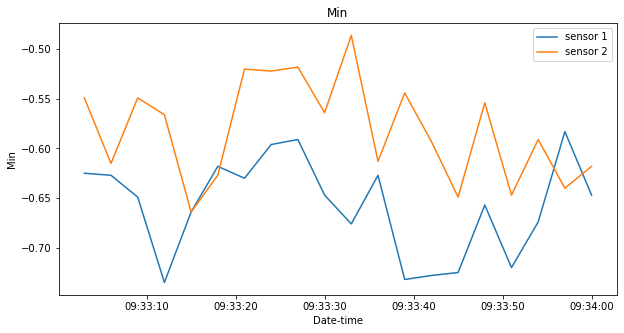

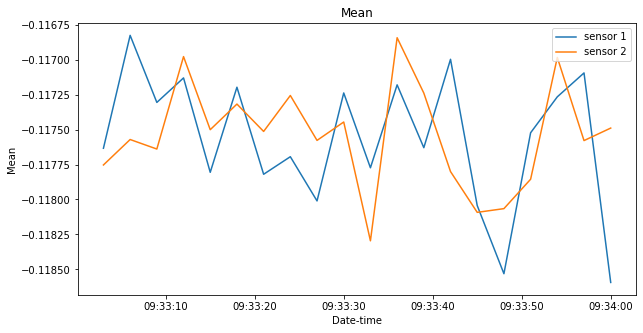

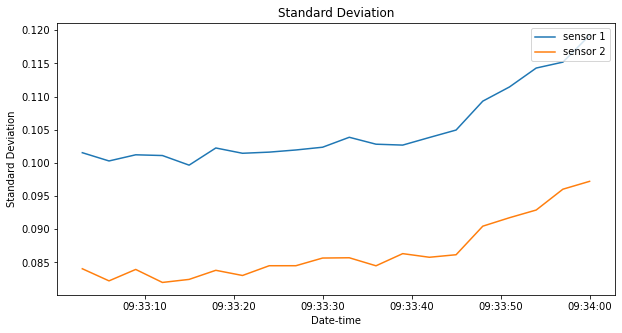

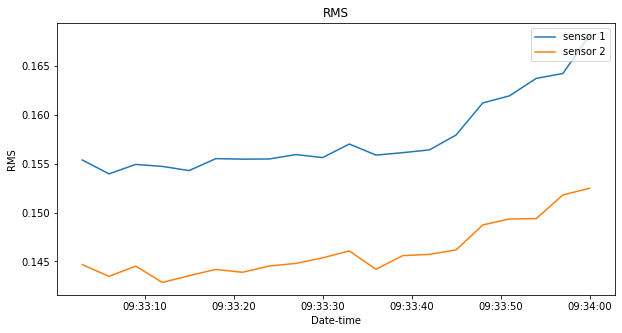

In [16]:
# Visualization of 20 timestamps contianing ok and not ok. 

# Features of each sensor:
feature_rs1= clipped_features[['S1_max','S1_min','S1_mean','S1_std','S1_rms']]
feature_rs2= clipped_features[['S2_max','S2_min','S2_mean','S2_std','S2_rms']]

feature_rs1.columns=['Max','Min','Mean','Standard Deviation','RMS']
feature_rs2.columns=['Max','Min','Mean','Standard Deviation','RMS']

for i, col in enumerate(feature_rs1.columns):

    plt.figure(figsize=(10,5))
    plt.plot(clipped_features.index, feature_rs1[col], label ='sensor 1')
    plt.plot(clipped_features.index, feature_rs2[col], label= 'sensor 2')
    plt.legend(loc='upper right')
    plt.xlabel('Date-time')
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [17]:
# Read 2 files with ok value and not ok value

file_ok = '2021-05-17_09-33-21'
vib_data_ok = pd.read_csv(vibration_folder/file_ok, sep = "\t", header = None)

file_not_ok = '2021-05-17_09-33-18'
vib_data_not_ok = pd.read_csv(vibration_folder/file_not_ok, sep = "\t", header = None)

new_df_s1= pd.DataFrame([])

new_df_s1['ok'] = vib_data_ok[0]
new_df_s1['not ok'] = vib_data_not_ok[0]
print(new_df_s1)

          ok  not ok
0     -0.044  -0.095
1     -0.085  -0.022
2     -0.107  -0.129
3     -0.088  -0.298
4     -0.107  -0.422
...      ...     ...
20475  0.056  -0.166
20476  0.000  -0.137
20477 -0.183   0.125
20478 -0.212  -0.073
20479 -0.264  -0.112

[20480 rows x 2 columns]


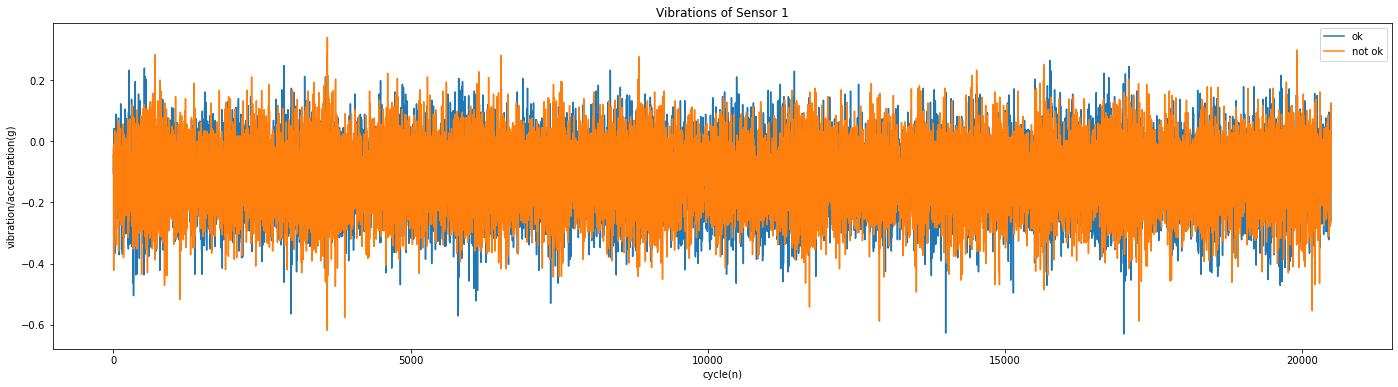

In [18]:
# Visualization containing 20k vibrations datapoints on sensor 1

ax = new_df_s1.plot(figsize = (24,6), title= "Vibrations of Sensor 1" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

### Modelling and Evaluation

In [19]:
features_train = ['S1_max','S1_min','S1_mean','S1_std','S1_rms','S2_max','S2_min','S2_mean','S2_std','S2_rms']
X_features = df_merged[features_train].to_numpy()
Y = df_merged['quality'].to_numpy()

# Encode labels: "OK" - 1 "nOK" - 0

Y = np.where(Y == 'OK',1,0)

In [64]:
# Split the feature matrix intro test and train

X_train, X_test, Y_train, Y_test = train_test_split(X_features,Y,test_size = 0.30)

In [65]:
# Instantiate the Scaler and the Classifier

scaler = StandardScaler()
logreg = LogisticRegression( solver = 'liblinear', class_weight = 'balanced')

In [66]:
# IGNORE: Junk code
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# model.fit(X_train, Y_train)
# preds = model.predict(X_test)

In [67]:
#Instantiate a pipeline object with Scaler and Classifier 

pipe = Pipeline([('scaler',scaler),("classifier",logreg)])

In [68]:
# Fit the pipeline object

pipe.fit(X_train,Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])

In [69]:
preds = pipe.predict(X_test)

In [74]:
# Should we use weighted average in metrics? It helps account for label imbalance

metrics.f1_score(Y_test, preds,average = 'weighted')

0.9110376544984191